# DCGAN on Face Images

## 1. Import packages

In [30]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# import pytorch packages
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision.utils import make_grid

# import progress bar
from tqdm.auto import tqdm

## 2. Prepare the dataset

In [31]:

data_root = '/home/sh2439/pytorch_tutorials/gender_detect/combined'



dataset = dsets.ImageFolder(root = data_root,
                            transform = transforms.Compose([
                                transforms.Resize(64),
#                                 transforms.CenterCrop(128),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
                            ])
                           )

**Show the dataset and make the dataset iterable.**

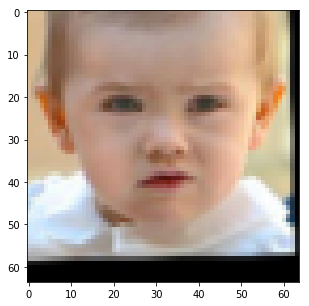

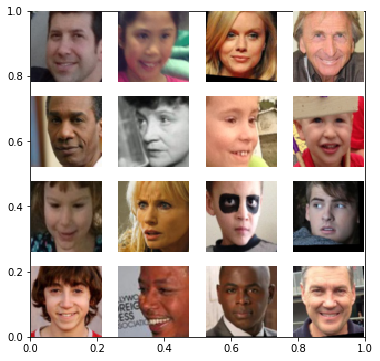

In [32]:
def show(img):
    """Given the tensor of image after the normalization, show the image.
    """
    # inverse normalization
    img = img * 0.5 + 0.5
    plt.figure(figsize = (5,5))
    plt.imshow(img.permute(1,2,0))
    plt.show()
    return

def show_grid(images, title = None, rows = 4):
    """Given the images tensors, show the multiple images
    """
    num = images.size(0)
    
    fig = plt.figure(figsize= (6,6))
    plt.title(title)
    cols = int(num/rows)
    
    for i in range(1, num+1):
        
        
        img = images[i-1]
        img = (img*0.5+0.5).permute(1,2,0)
        fig.add_subplot(rows, cols, i)
        plt.axis('off')
        plt.imshow(img)
    
    plt.show()
    return
    
    
# def show_grid():
    


a = dataset[0][0]
show(a)

batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset = dataset,
                                          batch_size = batch_size,
                                        shuffle = True)

samples = next(iter(data_loader))
sample_images = samples[0]
show_grid(sample_images[:16])

## 3. Build the model class

**Build the discriminator net**

In [33]:
class Dis_Net(nn.Module):
    """ The discriminator net. The size of input should be n*3*64*64 tensor.
    """
    def __init__(self):
        super(Dis_Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,64,kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.LeakyReLU(0.2, inplace = True)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True)
        )
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size= (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True)
        
        )
        
        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 1, kernel_size = (4,4), stride = (1,1), bias = False),
            nn.Sigmoid()
        
        )
        
    def forward(self, x):
        """Input: 3*64*64 tensors
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        return x
    
    
    

**Build the generator**

In [34]:
class Gen_Net(nn.Module):
    """ The generator net. The size of input should be n*100*1*1 tensor.
    """
    
    def __init__(self):
        super(Gen_Net, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(100, 512, kernel_size = (4,4), stride = (1,1), bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(True)
        )
        
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        
        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True)
        )
        
        self.layer4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(True)
        )
        self.layer5 = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size = (4,4), stride = (2,2), padding = (1,1), bias = False),
            nn.Tanh()
        )
        
    def forward(self, x):
        """Input: tensor of length z
        """
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        
        return x
        

## 4. Instantiate the model class

**Initialize the weights with normal distribution.**

In [35]:
### initialize the weights

Dis = Dis_Net()
Gen = Gen_Net()
# Dis


def init_weights(m):
    """ Intialize the weights of conv layer and batchnorm layer.
    """   
    if type(m) == nn.Conv2d:
        nn.init.normal_(m.weight.data, 0 , 0.02)
    elif type(m) == nn.BatchNorm2d:
        nn.init.normal_(m.weight.data, 1, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
# for para in Dis.state_dict():

#     print(para)
# for name, para in Dis.named_parameters():
#     print(name, para)
# for layer in Dis.modules():
#     print(layer, isinstance(layer, nn.Conv2d))
# for layer in Dis.children():
#     for sub_layer in layer.children():
#         print(type(sub_layer) == nn.Conv2d)
# print(Dis.__class__.__name__)

**Put the model to GPU and apply the initialization.**

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Dis.to(device)
Gen.to(device)
if torch.cuda.device_count() >1:
    Dis = nn.DataParallel(Dis)
    Gen = nn.DataParallel(Gen)
    torch.backends.cudnn.benchmark = True
    
Dis.apply(init_weights)
Gen.apply(init_weights)

DataParallel(
  (module): Gen_Net(
    (layer1): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (layer2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (layer3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
    )
    (layer4): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(in

### Loss and optimizers

In [37]:
# Use binary cross entropy loss
criterion = nn.BCELoss()

learning_rate = 0.0002
d_optimizer = torch.optim.Adam(Dis.parameters(), lr = learning_rate, betas = [0.5,0.999])
g_optimizer = torch.optim.Adam(Gen.parameters(), lr = learning_rate, betas = [0.5,0.999])

## 5. Train the model

**Define helper functions**

In [38]:
def get_noise(size):
    """ Generate random noise to feed into the generator. 
    """
    n = torch.randn(size, 100, 1,1, device = device)
    
    return n

# Create test image noise input.
torch.manual_seed(1)
test_noise = get_noise(16)
# print(test_noise.size())
# test_noise


def train_dis(model, optimizer, real_data, fake_data):
    """ Train the discriminator given the real and fake data.
    """
    # reset gradients
    optimizer.zero_grad()
    
    ### Train on real data
    preds_real = model(real_data)
    real_labels = Variable(torch.ones(real_data.size(0), 1, device = device))
    loss_real = criterion(preds_real, real_labels)
    
    loss_real.backward()
    
    ### Train on fake data
    preds_fake = model(fake_data)
    fake_labels = Variable(torch.zeros(fake_data.size(0), 1, device = device))
    loss_fake = criterion(preds_fake, fake_labels)
    
    loss_fake.backward()
    
    loss_D = loss_real + loss_fake
    # update
    optimizer.step()
    return loss_D, preds_real, preds_fake

def train_gen(model, optimizer, fake_data):
    """ Train the generator given the fake data.
    """
    
    optimizer.zero_grad()
    
    fake_preds_g = model(fake_data)
    real_labels = Variable(torch.ones(fake_data.size(0),1, device = device))
    # compute the loss
    loss_G = criterion(fake_preds_g, real_labels)
    
    loss_G.backward()
    
    # update
    optimizer.step()
    
    return loss_G, fake_preds_g

**Start Training**

/home/sh2439/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch:0, iters:0, loss_D:2.155735492706299, loss_G:3.95559024810791
D(x):0.5108669400215149, D(G(z1)):0.6630332469940186, D(G(z1)):0.03251168876886368
torch.Size([16, 3, 64, 64])


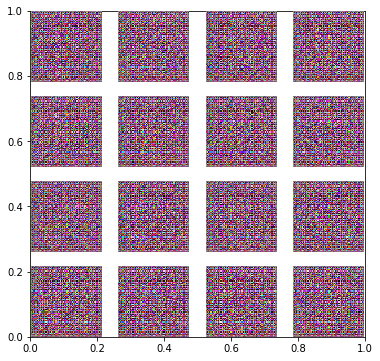

epoch:0, iters:50, loss_D:0.26781442761421204, loss_G:7.857125759124756
D(x):0.8792308568954468, D(G(z1)):0.010646754875779152, D(G(z1)):0.0006468383362516761
epoch:0, iters:100, loss_D:0.20088236033916473, loss_G:10.707504272460938
D(x):0.9497134685516357, D(G(z1)):0.1160934716463089, D(G(z1)):3.641716830316e-05
epoch:0, iters:150, loss_D:1.1676981449127197, loss_G:5.73261833190918
D(x):0.509081244468689, D(G(z1)):0.0030853210482746363, D(G(z1)):0.015866484493017197
epoch:0, iters:200, loss_D:0.8674435615539551, loss_G:2.376905918121338
D(x):0.5595315098762512, D(G(z1)):0.01398945041000843, D(G(z1)):0.21378567814826965
epoch:0, iters:250, loss_D:0.2521887719631195, loss_G:5.700428485870361
D(x):0.9267922043800354, D(G(z1)):0.14342334866523743, D(G(z1)):0.005267888307571411


/home/sh2439/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([94, 1])) that is different to the input size (torch.Size([94, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


epoch:1, iters:0, loss_D:0.43295302987098694, loss_G:7.314077854156494
D(x):0.8187701106071472, D(G(z1)):0.01778707653284073, D(G(z1)):0.002051068004220724
torch.Size([16, 3, 64, 64])


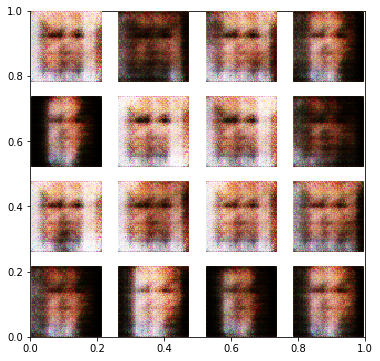

epoch:1, iters:50, loss_D:1.035966157913208, loss_G:3.640169620513916
D(x):0.47281110286712646, D(G(z1)):0.012867441400885582, D(G(z1)):0.04657282680273056
epoch:1, iters:100, loss_D:0.16515550017356873, loss_G:4.2659478187561035
D(x):0.9271963834762573, D(G(z1)):0.07635226100683212, D(G(z1)):0.023382164537906647
epoch:1, iters:150, loss_D:1.0720034837722778, loss_G:1.0899890661239624
D(x):0.481945663690567, D(G(z1)):0.006955225020647049, D(G(z1)):0.3935040235519409
epoch:1, iters:200, loss_D:0.16715648770332336, loss_G:4.484839916229248
D(x):0.9520832300186157, D(G(z1)):0.10147197544574738, D(G(z1)):0.022170836105942726
epoch:1, iters:250, loss_D:0.40404945611953735, loss_G:5.539794921875
D(x):0.9438959360122681, D(G(z1)):0.27021849155426025, D(G(z1)):0.008996759541332722
epoch:2, iters:0, loss_D:0.6145056486129761, loss_G:9.093320846557617
D(x):0.9770499467849731, D(G(z1)):0.40065503120422363, D(G(z1)):0.000759801478125155
torch.Size([16, 3, 64, 64])


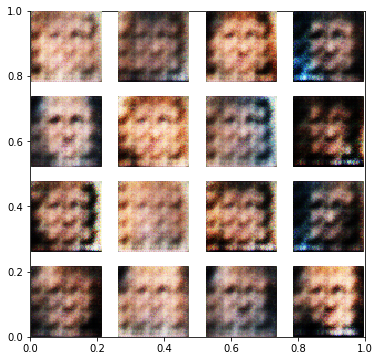

epoch:2, iters:50, loss_D:0.7379769682884216, loss_G:4.492356300354004
D(x):0.8979402780532837, D(G(z1)):0.4046602249145508, D(G(z1)):0.02338629961013794
epoch:2, iters:100, loss_D:0.2761751115322113, loss_G:4.562044143676758
D(x):0.9353266358375549, D(G(z1)):0.16734227538108826, D(G(z1)):0.020822331309318542
epoch:2, iters:150, loss_D:0.4695245027542114, loss_G:4.405069351196289
D(x):0.8056021928787231, D(G(z1)):0.14595700800418854, D(G(z1)):0.01713762991130352
epoch:2, iters:200, loss_D:0.4951896071434021, loss_G:2.300461769104004
D(x):0.7313536405563354, D(G(z1)):0.07828263938426971, D(G(z1)):0.14321357011795044
epoch:2, iters:250, loss_D:0.4362039268016815, loss_G:4.786643981933594
D(x):0.8679651021957397, D(G(z1)):0.20802302658557892, D(G(z1)):0.015398150309920311
epoch:3, iters:0, loss_D:1.3638943433761597, loss_G:1.1678763628005981
D(x):0.3760225474834442, D(G(z1)):0.04035750404000282, D(G(z1)):0.39418986439704895
torch.Size([16, 3, 64, 64])


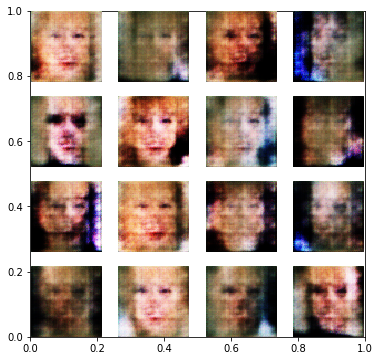

epoch:3, iters:50, loss_D:0.3428570330142975, loss_G:3.6961770057678223
D(x):0.9474074840545654, D(G(z1)):0.22811628878116608, D(G(z1)):0.03907176852226257
epoch:3, iters:100, loss_D:0.6719344854354858, loss_G:7.0109758377075195
D(x):0.9061758518218994, D(G(z1)):0.39806658029556274, D(G(z1)):0.001801883801817894
epoch:3, iters:150, loss_D:0.5368412733078003, loss_G:3.5413453578948975
D(x):0.8698129653930664, D(G(z1)):0.28222960233688354, D(G(z1)):0.050510670989751816
epoch:3, iters:200, loss_D:0.894037127494812, loss_G:3.3044748306274414
D(x):0.6759128570556641, D(G(z1)):0.2844301462173462, D(G(z1)):0.05146515369415283
epoch:3, iters:250, loss_D:0.27921995520591736, loss_G:3.488654613494873
D(x):0.8651189804077148, D(G(z1)):0.10369683057069778, D(G(z1)):0.04555797576904297
epoch:4, iters:0, loss_D:3.3297574520111084, loss_G:7.379291534423828
D(x):0.10853219032287598, D(G(z1)):0.0004369427915662527, D(G(z1)):0.001664467854425311
torch.Size([16, 3, 64, 64])


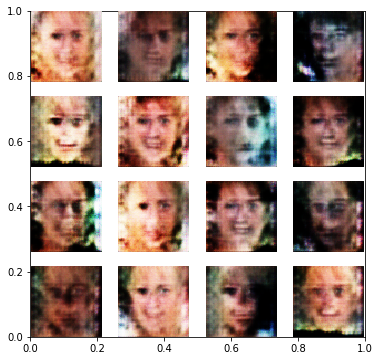

epoch:4, iters:50, loss_D:0.9358773827552795, loss_G:6.53911018371582
D(x):0.8978093862533569, D(G(z1)):0.5035647749900818, D(G(z1)):0.002992782276123762
epoch:4, iters:100, loss_D:0.4864208400249481, loss_G:4.709842681884766
D(x):0.6969324350357056, D(G(z1)):0.025440147146582603, D(G(z1)):0.023197025060653687
epoch:4, iters:150, loss_D:0.6601663827896118, loss_G:1.5260703563690186
D(x):0.6571588516235352, D(G(z1)):0.13185453414916992, D(G(z1)):0.2880112826824188
epoch:4, iters:200, loss_D:0.39394742250442505, loss_G:2.7381327152252197
D(x):0.7536486387252808, D(G(z1)):0.0663570836186409, D(G(z1)):0.08330828696489334
epoch:4, iters:250, loss_D:0.7281637787818909, loss_G:2.5896077156066895
D(x):0.564708948135376, D(G(z1)):0.027670016512274742, D(G(z1)):0.10596001148223877
epoch:5, iters:0, loss_D:1.1677687168121338, loss_G:1.0597518682479858
D(x):0.40091291069984436, D(G(z1)):0.03978580981492996, D(G(z1)):0.4030640721321106
torch.Size([16, 3, 64, 64])


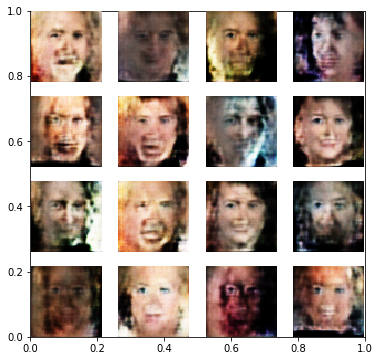

epoch:5, iters:50, loss_D:0.5418926477432251, loss_G:1.8855007886886597
D(x):0.7130361795425415, D(G(z1)):0.1312999427318573, D(G(z1)):0.18870890140533447
epoch:5, iters:100, loss_D:0.6218470335006714, loss_G:1.4338053464889526
D(x):0.677990198135376, D(G(z1)):0.1519795060157776, D(G(z1)):0.28777632117271423
epoch:5, iters:150, loss_D:0.7362775802612305, loss_G:1.8255105018615723
D(x):0.6118974685668945, D(G(z1)):0.13535857200622559, D(G(z1)):0.20824044942855835
epoch:5, iters:200, loss_D:0.7631309628486633, loss_G:3.986722230911255
D(x):0.8308098912239075, D(G(z1)):0.3978063762187958, D(G(z1)):0.026369966566562653
epoch:5, iters:250, loss_D:0.5226513147354126, loss_G:3.1530203819274902
D(x):0.798274040222168, D(G(z1)):0.22390013933181763, D(G(z1)):0.06257687509059906
epoch:6, iters:0, loss_D:1.5964435338974, loss_G:5.42069149017334
D(x):0.9690319299697876, D(G(z1)):0.7125238180160522, D(G(z1)):0.00861552357673645
torch.Size([16, 3, 64, 64])


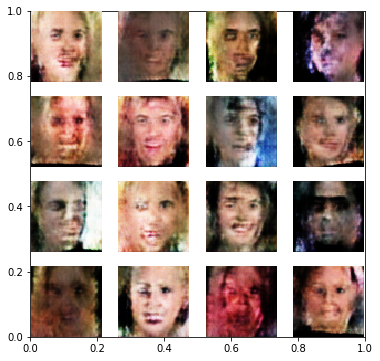

epoch:6, iters:50, loss_D:1.611206293106079, loss_G:5.248089790344238
D(x):0.9658074378967285, D(G(z1)):0.73740553855896, D(G(z1)):0.012053794227540493
epoch:6, iters:100, loss_D:0.37964004278182983, loss_G:3.5853517055511475
D(x):0.8931163549423218, D(G(z1)):0.2087612748146057, D(G(z1)):0.04468798637390137
epoch:6, iters:150, loss_D:0.7370527386665344, loss_G:4.212389945983887
D(x):0.9501779079437256, D(G(z1)):0.4535002112388611, D(G(z1)):0.024452513083815575


KeyboardInterrupt: 

In [39]:
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    
    for batch_idx, (real_images, _) in enumerate(data_loader):
        
        ### Train the discriminator
        
        # process real and fake data
        real_images = Variable(real_images).to(device)
        noise = get_noise(real_images.size(0))
        fake_images = Gen(noise)
        # train the discriminator
        loss_D, preds_real, preds_fake = train_dis(Dis, d_optimizer, real_images, fake_images)
        
        
        ### Train the generator
        noise = get_noise(real_images.size(0))
        fake_images = Gen(noise)
        
        loss_G, preds_fake_g = train_gen(Dis, g_optimizer, fake_images)
        
        ### Compute the D(x), D(G(z1)), and D(G(z2))
        
        D_x = preds_real.mean().cpu()
        D_G_z1 = preds_fake.mean().cpu()
        D_G_z2 = preds_fake_g.mean().cpu()
        
        if batch_idx % 50 == 0:
            print('epoch:{}, iters:{}, loss_D:{}, loss_G:{}'.format(epoch, batch_idx, loss_D.item(), loss_G.item()))
            
            print('D(x):{}, D(G(z1)):{}, D(G(z1)):{}'.format(D_x, D_G_z1, D_G_z2))
            
        # show the test images every 500 iters
        
        if batch_idx % 500 == 0:
            test_imgs = Gen(test_noise).cpu().detach()
            print(test_imgs.size())
            show_grid(test_imgs)
            
        
        
        
        